In this group of notebook we will test the methods implemented in the library to check if they can improve the results of the models.

In order to be as impartial as possible, we will use a KFold evaluation for each combination, with a k-value of five.

In this particular notebook, we will train the model using the `CarveMix` technique.

In [ ]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from semantic_segmentation_augmentations.holemakertechnique import HoleMakerROI
from semantic_segmentation_augmentations.holesfilling import CarveMix

from vision_models_evaluation.core import evaluate

from sklearn.model_selection import KFold

import pandas as pd

import matplotlib.pyplot as plt

import PIL
import torchvision.transforms as transforms
from pathlib import Path
import random

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch; torch.cuda.set_device(1)

Then, we prepare the scenario: we are going to use a grape vine dataset where the semantic problem to tackle is to segmentate the RGB images into wood, leaves, grape and pole classes.

Finally, we define here the mapping functions and the masks transformations.

In [ ]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"

def get_y_fn (x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

codes = np.loadtxt(path/'codesAll.txt', dtype=str)

def ParentSplitter(x):
    return Path(x).parent.name==test_name

from albumentations import (
  Compose,
  OneOf,
  ElasticTransform,
  GridDistortion, 
  OpticalDistortion,
  HorizontalFlip,
  Rotate,
  Transpose,
  CLAHE,
  ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0

    def __init__(self, aug): 
        self.aug = aug

    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transforms)

class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x

        #Convert to array
        mask = np.array(mask)

        # background = 0, leaves = 1, pole = 74 o 76, wood = 25 o 29, grape = 255
        mask[mask == 255] = 1 # grape
        mask[mask == 150] = 2 # leaves
        mask[mask == 76] = 3 ; mask[mask == 74] = 3 # pole
        mask[mask == 29] = 4 ; mask[mask == 25] = 4 # wood
        mask[mask >= 5] = 0 # resto: background

        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

While training, we will use the EarlyStopping strategy: after five epoch without improvements, the training will be stopped.

In [ ]:
esc = EarlyStoppingCallback(patience = 5, min_delta = 0.01)

Then, we define all the hparams (hyperparameters) to build the datablocks, dataloaders and learners.

In [ ]:
db_hparams = {
    "blocks": (ImageBlock, MaskBlock(codes)),
    "get_items": get_image_files,
    "get_y": get_y_fn,
    "splitter": RandomSplitter(valid_pct=0.2),
    "item_tfms": [Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
    "batch_tfms": Normalize.from_stats(*imagenet_stats)
}

dls_hparams = {
    "source": path_images,
    "bs": 2,
    "pin_memory": False
}

technique = KFold(n_splits = 5)

learner_hparams = {
    "arch": resnet50,
    "pretrained": True,
    "metrics": [DiceMulti()],
    "cbs": []
}

learning_hparams = {
    "epochs": 30,
    "base_lr": 0.001,
    "freeze_epochs": 3
}

learning_mode = "finetune"

In order to know how does this technique work, we can show an example.

This technique cuts a region of interesi (ROI) from an image (a region that contains a group of pixels of a class) and put them into another image.

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (training) that exists in the learner. Use `self.learn.training` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


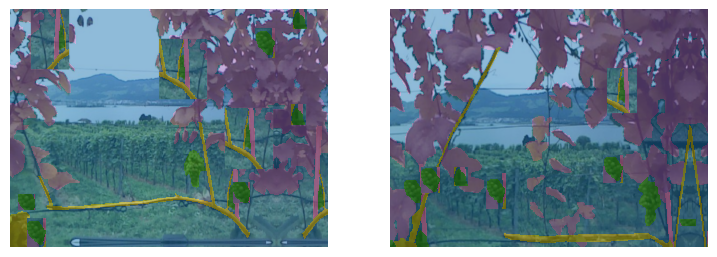

In [ ]:
cv = CarveMix(holes_num = 10, ROI_class = 1, delta_ratio = None, random_position = True, p = 1)
dls = DataBlock(**db_hparams).dataloaders(**dls_hparams)
with Learner(dls, resnet50(), metrics=[DiceMulti()], cbs = cv) as learn:
    learn.epoch, learn.training = 0, True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_, axs = plt.subplots(1, 2, figsize=(9, 9))
dls.show_batch(b = (cv.x, cv.y), ctxs = axs.flatten())

Finally, we test the model with distinct hparams.

In [ ]:
results = {}

for holes_num in [1, 3, 5]:
    for ROI_class in [1, -1]:
        for position in [True, False]:
            cm = CarveMix(holes_num, None, ROI_class, position)
            learner_hparams["cbs"] = [esc, cm]
            r = evaluate(db_hparams,
                         dls_hparams,
                         technique,
                         learner_hparams,
                         learning_hparams,
                         learning_mode
                        )
            results.update({
                str(holes_num) + str(ROI_class) + str(position): r["DiceMulti"]
            })

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,dice_multi,time
0,0.935902,0.615783,0.341026,00:21
1,0.681632,0.521638,0.338621,00:19
2,0.696256,0.880716,0.345459,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.481330,0.444473,0.506679,00:20
1,0.425949,0.414684,0.553563,00:19
2,0.381726,0.365645,0.630449,00:20
3,0.349880,0.358183,0.665901,00:20
4,0.331628,0.313996,0.782669,00:20
5,0.308062,0.315053,0.780871,00:19
6,0.319153,0.526420,0.771000,00:19
7,0.314118,0.292303,0.813136,00:20
8,0.286465,0.316427,0.808690,00:20
9,0.268873,0.277324,0.829046,00:20


No improvement since epoch 9: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.830659,0.549714,0.351872,00:19
1,0.606229,0.389670,0.471808,00:19
2,5.704428,1.008542,0.237877,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.658910,0.466960,0.350567,00:20
1,0.509063,0.392437,0.354864,00:20
2,0.451727,0.392449,0.425094,00:20
3,0.408979,0.330886,0.507682,00:20
4,0.381682,0.297893,0.741867,00:20
5,0.343467,0.277753,0.749412,00:20
6,0.325182,0.271459,0.752521,00:20
7,0.320951,0.272862,0.801344,00:20
8,0.317559,0.275770,0.797184,00:20
9,0.305224,0.256201,0.802222,00:20


No improvement since epoch 14: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.880579,0.681820,0.326093,00:20
1,0.700934,0.483434,0.353691,00:19
2,0.583301,0.382453,0.409352,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.382819,0.340814,0.590171,00:20
1,0.353732,0.350669,0.670827,00:20
2,0.343197,0.322808,0.729134,00:20
3,0.323436,0.295619,0.786613,00:20
4,0.311480,0.331836,0.765681,00:20
5,0.301497,0.316882,0.754802,00:20
6,0.290591,0.272817,0.779512,00:20
7,0.288001,0.301017,0.788962,00:20
8,0.285043,0.363399,0.721496,00:20
9,0.272578,0.269783,0.815165,00:20


No improvement since epoch 6: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.999533,0.567361,0.328874,00:20
1,0.702533,0.680026,0.247663,00:20
2,0.690420,0.577662,0.405309,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.423698,0.308722,0.572804,00:20
1,0.392339,0.265010,0.649484,00:20
2,0.363899,0.252746,0.733161,00:20
3,0.333788,0.250238,0.808970,00:20
4,0.318994,0.252544,0.703631,00:20
5,0.326265,0.247063,0.767191,00:20
6,0.321977,0.236716,0.794892,00:20
7,0.304375,0.267489,0.783127,00:20
8,0.312724,0.252170,0.746500,00:20
9,0.306418,0.243529,0.817793,00:20


No improvement since epoch 12: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.907256,0.596726,0.336623,00:20
1,0.730648,0.812946,0.291734,00:20
2,0.595329,0.523769,0.371267,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.423691,0.371685,0.616993,00:20
1,0.375362,0.317958,0.703895,00:20
2,0.368038,0.308276,0.743555,00:20
3,0.345980,0.287924,0.776526,00:20
4,0.325665,0.282193,0.790184,00:20
5,0.311728,0.329920,0.771281,00:20
6,0.306303,0.326959,0.762029,00:20
7,0.299039,0.274611,0.803675,00:20
8,0.284626,0.279626,0.802472,00:20
9,0.280458,0.250657,0.819637,00:20


No improvement since epoch 9: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.032520,0.567827,0.329755,00:19
1,0.678166,0.578819,0.395179,00:20
2,0.611171,0.536446,0.335425,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.391312,0.483531,0.580317,00:20
1,0.349608,0.441010,0.646305,00:20
2,0.317720,0.582131,0.647336,00:20
3,0.293401,0.424068,0.644440,00:20
4,0.279112,0.499173,0.689785,00:20
5,0.271001,0.429374,0.696483,00:20
6,0.271006,0.378002,0.715560,00:20
7,0.259852,0.392768,0.700237,00:20
8,0.275392,0.406280,0.730308,00:20
9,0.262064,0.371212,0.744612,00:20


No improvement since epoch 6: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.998328,0.823645,0.275682,00:20
1,0.703160,0.447340,0.410557,00:20
2,0.612631,0.398905,0.411928,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.378605,0.318654,0.712706,00:20
1,0.349032,0.298014,0.760413,00:20
2,0.326695,0.273369,0.776983,00:20
3,0.322825,0.291356,0.725474,00:20
4,0.335692,0.379292,0.716260,00:20
5,0.338596,0.294413,0.740069,00:20
6,0.316362,0.291232,0.741580,00:20
7,0.297936,0.264467,0.782440,00:20


No improvement since epoch 2: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.985889,0.665178,0.334271,00:20
1,0.682391,0.383980,0.440089,00:20
2,0.646556,0.511147,0.340851,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.439077,0.389291,0.571783,00:20
1,0.408658,0.393363,0.562213,00:20
2,0.368367,0.296147,0.738945,00:20
3,0.352176,0.345736,0.758153,00:20
4,0.334227,0.293315,0.724630,00:20
5,0.321254,0.288579,0.780524,00:20
6,0.313637,0.308457,0.686655,00:20
7,0.304547,0.364907,0.743805,00:20


No improvement since epoch 2: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.271610,0.568960,0.324407,00:20
1,0.780819,0.366042,0.426801,00:20
2,0.593032,0.287256,0.566696,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.366690,0.265680,0.612962,00:20
1,0.339597,0.285519,0.690592,00:20
2,0.336268,0.246348,0.756826,00:20
3,0.327820,0.254312,0.755586,00:20
4,0.313384,0.238093,0.805360,00:20
5,0.320619,0.238497,0.801536,00:20
6,0.310719,0.259672,0.727813,00:21
7,0.305639,0.232976,0.813911,00:20
8,0.312995,0.277100,0.814504,00:20
9,0.297387,0.244215,0.826840,00:20


No improvement since epoch 10: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.968996,0.530330,0.343293,00:20
1,0.700454,0.821654,0.301281,00:20
2,0.781341,0.983293,0.214216,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.552500,0.449893,0.401281,00:21
1,0.473448,0.387251,0.422176,00:20
2,0.423558,0.371256,0.546614,00:20
3,0.388169,0.406231,0.596936,00:21
4,0.352111,0.288656,0.741227,00:20
5,0.327883,0.316561,0.709599,00:20
6,0.310615,0.275295,0.747497,00:20
7,0.296482,0.273133,0.771544,00:20
8,0.288989,0.304672,0.774247,00:20
9,0.302582,0.271961,0.767786,00:20


No improvement since epoch 12: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.018366,0.725671,0.290901,00:20
1,0.697373,0.639023,0.365372,00:20
2,0.557698,0.544392,0.378329,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.340650,0.460544,0.571694,00:20
1,0.309606,0.423994,0.642198,00:21
2,0.312761,0.486739,0.688931,00:20
3,0.294302,0.478326,0.690447,00:20
4,0.270855,0.402219,0.691639,00:21
5,0.268192,0.543377,0.686914,00:20
6,0.258545,0.423661,0.640305,00:20
7,0.261203,0.417730,0.694826,00:20
8,0.250306,0.367634,0.726041,00:20
9,0.245867,0.447858,0.716671,00:20


No improvement since epoch 8: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.092729,0.775252,0.336914,00:20
1,0.742443,0.512235,0.349690,00:20
2,0.654614,1.009562,0.278086,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.472465,0.398957,0.414552,00:20
1,0.429763,0.359758,0.505703,00:20
2,0.384178,0.315625,0.726928,00:20
3,0.363590,0.301541,0.758953,00:20
4,0.359212,0.319449,0.716763,00:20
5,0.333058,0.291767,0.790648,00:20
6,0.339777,0.345198,0.646424,00:21
7,0.333019,0.278663,0.744746,00:21
8,0.311532,0.281728,0.805747,00:20
9,0.293361,0.252229,0.806497,00:20


No improvement since epoch 9: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.037985,0.602355,0.338446,00:20
1,0.714046,0.467515,0.354493,00:20
2,0.625952,0.551972,0.339868,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.405386,0.343067,0.574071,00:20
1,0.360786,0.324644,0.698029,00:21
2,0.337302,0.297040,0.739426,00:20
3,0.329893,0.401064,0.662087,00:21
4,0.338100,0.302880,0.776951,00:21
5,0.314650,0.273533,0.786055,00:21
6,0.343062,0.453711,0.499548,00:21
7,0.371224,0.310882,0.733598,00:21
8,0.327750,0.281867,0.783003,00:21
9,0.300538,0.310564,0.780506,00:21


No improvement since epoch 5: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.909162,0.630469,0.332734,00:20
1,0.667168,0.650331,0.268901,00:20
2,1.028671,1.054521,0.220713,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.590968,0.393686,0.358050,00:20
1,0.495020,0.349630,0.392850,00:20
2,0.458661,0.295107,0.592962,00:20
3,0.435373,0.297034,0.574642,00:21
4,0.392082,0.283455,0.696502,00:21
5,0.366143,0.256100,0.737689,00:21
6,0.338233,0.255033,0.755948,00:20
7,0.334974,0.292510,0.790996,00:21
8,0.315647,0.242373,0.787799,00:20
9,0.295387,0.223899,0.819180,00:20


No improvement since epoch 12: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.966066,0.643522,0.331380,00:20
1,0.733458,0.474167,0.349847,00:20
2,0.621337,0.465678,0.357272,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.404851,0.383632,0.530088,00:21
1,0.367296,0.321405,0.684008,00:21
2,0.342188,0.285834,0.726580,00:20
3,0.326281,0.315641,0.686059,00:21
4,0.322263,0.308578,0.746171,00:21
5,0.309900,0.288806,0.741365,00:20
6,0.312364,0.281512,0.728835,00:20
7,0.303605,0.275650,0.798868,00:20
8,0.289579,0.268043,0.807439,00:21
9,0.274658,0.273759,0.811561,00:21


No improvement since epoch 13: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.979182,0.776937,0.298652,00:20
1,0.670756,0.509624,0.390267,00:20
2,0.568951,0.649184,0.346322,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.377874,0.449703,0.631103,00:20
1,0.338884,0.447809,0.616979,00:20
2,0.308660,0.389464,0.662766,00:20
3,0.291847,0.496564,0.684608,00:20
4,0.275766,0.456075,0.686651,00:20
5,0.262549,0.379927,0.723690,00:21
6,0.278186,0.457394,0.651777,00:21
7,0.274401,0.402448,0.689395,00:21


No improvement since epoch 2: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.849820,0.757917,0.273603,00:20
1,0.683888,0.602578,0.333308,00:21
2,0.685128,0.687232,0.338091,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.488557,0.400736,0.401428,00:20
1,0.429284,0.348185,0.593430,00:21
2,0.398909,0.404072,0.535305,00:21
3,0.374141,0.370955,0.637208,00:21
4,0.366027,0.316439,0.638200,00:20
5,0.345402,0.293257,0.743106,00:20
6,0.340801,0.288716,0.740225,00:21
7,0.330697,0.280366,0.779828,00:21
8,0.315244,0.278458,0.742135,00:21
9,0.309302,0.293635,0.702688,00:21


No improvement since epoch 7: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.007915,0.637593,0.338964,00:20
1,0.727848,0.408422,0.401381,00:20
2,0.612011,0.395437,0.411773,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.386078,0.350447,0.576014,00:21
1,0.383154,0.355278,0.692474,00:21
2,0.345540,0.293534,0.757772,00:20
3,0.330947,0.334691,0.730340,00:21
4,0.312681,0.287333,0.771024,00:21
5,0.307242,0.287043,0.782020,00:21
6,0.308427,0.275368,0.795157,00:20
7,0.311619,0.276282,0.772998,00:21
8,0.300048,0.279478,0.807077,00:20
9,0.282185,0.275336,0.805758,00:20


No improvement since epoch 11: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.984831,0.591317,0.334899,00:21
1,0.677917,0.529893,0.464889,00:21
2,1.084999,1.214554,0.198500,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.564346,0.350834,0.604737,00:21
1,0.451029,0.293855,0.612992,00:21
2,0.394282,0.278185,0.759726,00:21
3,0.355605,0.232068,0.807114,00:21
4,0.340788,0.270258,0.762439,00:21
5,0.328322,0.276837,0.787305,00:21
6,0.318624,0.298410,0.744523,00:21
7,0.315818,0.266403,0.772262,00:21
8,0.305482,0.230144,0.826540,00:21


No improvement since epoch 3: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.896469,0.762973,0.302345,00:21
1,0.654410,0.817411,0.250662,00:21
2,0.623619,0.497305,0.353124,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.416123,0.370029,0.469892,00:21
1,0.373247,0.347540,0.602931,00:21
2,0.351260,0.312613,0.660297,00:21
3,0.332556,0.324013,0.737807,00:21
4,0.324718,0.316638,0.777889,00:21
5,0.311538,0.303349,0.750161,00:21
6,0.304937,0.319292,0.761839,00:21
7,0.298497,0.306240,0.742329,00:21


No improvement since epoch 2: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.062006,0.710858,0.288468,00:20
1,0.661070,0.474189,0.415569,00:21
2,1.011912,0.992174,0.177949,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.593858,0.517386,0.390576,00:21
1,0.483926,0.448340,0.403054,00:21
2,0.428016,0.566936,0.517373,00:21
3,0.375722,0.500968,0.613737,00:21
4,0.334502,0.611002,0.597065,00:21
5,0.314338,0.442881,0.677974,00:21
6,0.308521,0.454051,0.681031,00:21


No improvement since epoch 1: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.067816,0.651050,0.343818,00:21
1,0.709110,0.440817,0.356652,00:21
2,0.587031,0.565840,0.329535,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.383448,0.308865,0.620597,00:21
1,0.349788,0.280347,0.757641,00:21
2,0.329810,0.273491,0.754846,00:21
3,0.310725,0.255688,0.801124,00:21
4,0.309396,0.291605,0.767135,00:21
5,0.301950,0.275598,0.802552,00:21
6,0.311111,0.296135,0.771620,00:21
7,0.309976,0.274478,0.808121,00:21
8,0.292147,0.272951,0.779350,00:21


No improvement since epoch 3: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.853630,0.865138,0.293517,00:20
1,0.696778,0.528012,0.341494,00:21
2,0.623442,0.484018,0.477043,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.389052,0.328190,0.648426,00:21
1,0.360353,0.352798,0.693086,00:21
2,0.341129,0.293174,0.768359,00:21
3,0.325056,0.301491,0.759481,00:21
4,0.315937,0.321862,0.750166,00:21
5,0.319761,0.423730,0.727956,00:21
6,0.313206,0.267971,0.787330,00:21
7,0.302513,0.319811,0.741835,00:21
8,0.291948,0.257187,0.817534,00:21
9,0.281793,0.322538,0.781914,00:21


No improvement since epoch 8: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.108956,0.624967,0.347845,00:20
1,0.745366,0.419194,0.442461,00:21
2,0.588547,0.312837,0.539317,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.388451,0.286408,0.698627,00:21
1,0.364742,0.254296,0.730244,00:21
2,0.354329,0.237663,0.804568,00:21
3,0.334639,0.236690,0.785623,00:21
4,0.322395,0.231390,0.822020,00:21
5,0.324629,0.258377,0.804257,00:21
6,0.328281,0.237813,0.803200,00:21
7,0.309098,0.240324,0.807004,00:21


No improvement since epoch 2: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.713850,0.536616,0.348714,00:21
1,0.593218,0.574266,0.345795,00:21
2,1.322246,0.924789,0.247224,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.599663,0.490466,0.378229,00:21
1,0.503775,0.428781,0.392589,00:21
2,0.454680,0.398422,0.452848,00:21
3,0.424534,0.452945,0.501718,00:21
4,0.402584,0.342517,0.592686,00:21
5,0.384771,0.360466,0.590738,00:21
6,0.355035,0.349154,0.590592,00:21
7,0.348924,0.363034,0.552390,00:21
8,0.338257,0.329380,0.742977,00:21
9,0.313880,0.286025,0.771073,00:21


No improvement since epoch 19: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.802814,0.509852,0.336610,00:20
1,0.593315,0.634183,0.376633,00:21
2,0.620126,0.882325,0.196686,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.493686,0.668155,0.394416,00:21
1,0.419802,0.427814,0.584886,00:21
2,0.366260,0.421255,0.663489,00:21
3,0.332989,0.474864,0.646209,00:21
4,0.305004,0.531179,0.626127,00:21
5,0.294894,0.405428,0.685115,00:21
6,0.303795,0.365142,0.723649,00:21
7,0.285210,0.438584,0.706001,00:21
8,0.261952,0.396448,0.711443,00:21
9,0.248094,0.380606,0.730262,00:21


No improvement since epoch 6: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.919218,0.618777,0.331617,00:20
1,0.653613,0.413649,0.393382,00:21
2,0.618956,0.809878,0.348214,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.476536,0.401669,0.546508,00:21
1,0.410921,0.343358,0.639954,00:21
2,0.395922,0.393990,0.630163,00:21
3,0.365103,0.298020,0.667564,00:21
4,0.332823,0.275803,0.797925,00:21
5,0.314761,0.272470,0.762974,00:21
6,0.299880,0.278308,0.769088,00:21
7,0.305974,0.296577,0.799828,00:21
8,0.300388,0.263299,0.797164,00:21
9,0.286406,0.266452,0.787917,00:21


No improvement since epoch 8: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.090138,0.588974,0.330212,00:21
1,0.721414,0.403003,0.387456,00:21
2,0.604255,0.455198,0.563484,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.395492,0.349230,0.616655,00:21
1,0.355390,0.304849,0.701040,00:21
2,0.330704,0.327902,0.680497,00:21
3,0.320575,0.315253,0.766555,00:21
4,0.321892,0.298116,0.729192,00:21
5,0.308570,0.366426,0.751126,00:21
6,0.298313,0.292387,0.778052,00:21
7,0.286632,0.268513,0.809663,00:21
8,0.287562,0.340077,0.776027,00:21
9,0.266096,0.268895,0.802928,00:21


No improvement since epoch 7: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.010641,0.520393,0.339502,00:21
1,0.700167,0.611517,0.346085,00:21
2,0.665877,0.562643,0.333343,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.435062,0.338793,0.402858,00:21
1,0.394219,0.272432,0.670505,00:21
2,0.371804,0.268529,0.780266,00:21
3,0.344121,0.240538,0.791953,00:21
4,0.328870,0.229884,0.801949,00:21
5,0.325955,0.300051,0.692582,00:21
6,0.310208,0.241297,0.728999,00:21
7,0.309654,0.352379,0.682018,00:21
8,0.300775,0.224205,0.829925,00:21
9,0.292996,0.230875,0.806005,00:21


No improvement since epoch 4: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.023404,0.579511,0.339896,00:20
1,0.732386,0.515964,0.353006,00:21
2,0.685723,0.637323,0.317973,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.452983,0.365887,0.573583,00:21
1,0.396958,0.319929,0.659560,00:21
2,0.362473,0.308841,0.761182,00:21
3,0.342757,0.303046,0.722821,00:21
4,0.330755,0.276930,0.793400,00:21
5,0.314120,0.261760,0.763450,00:21
6,0.301770,0.371769,0.760069,00:21
7,0.312491,0.297623,0.783011,00:21
8,0.317128,0.275479,0.792783,00:21
9,0.296669,0.307347,0.807916,00:21


No improvement since epoch 5: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.945404,0.619654,0.310570,00:21
1,0.851167,0.788432,0.283317,00:21
2,0.779498,0.614097,0.359811,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.462892,0.582866,0.381029,00:21
1,0.418800,0.506840,0.414606,00:21
2,0.373892,0.475884,0.549722,00:21
3,0.345540,0.482325,0.638742,00:21
4,0.315862,0.444216,0.674658,00:21
5,0.301065,0.420961,0.631577,00:21
6,0.285119,0.371272,0.684730,00:21
7,0.285619,0.445362,0.700347,00:21
8,0.275946,0.440984,0.680012,00:21
9,0.270850,0.399136,0.725275,00:21


No improvement since epoch 6: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.770580,0.503010,0.352192,00:21
1,0.683272,0.587171,0.348063,00:21
2,0.694388,0.638309,0.356564,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.480678,0.468804,0.483778,00:22
1,0.428010,0.412835,0.530782,00:21
2,0.398792,0.322661,0.639683,00:21
3,0.379631,0.284841,0.772499,00:21
4,0.349573,0.300228,0.765027,00:21
5,0.331734,0.267098,0.788806,00:21
6,0.312172,0.295352,0.789698,00:21
7,0.301401,0.293160,0.743612,00:21
8,0.295495,0.345763,0.760707,00:21
9,0.303620,0.279055,0.769280,00:21


No improvement since epoch 5: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.889862,0.648333,0.317716,00:21
1,0.649427,0.511588,0.335521,00:21
2,0.685522,1.039913,0.134324,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.552471,0.391379,0.443078,00:22
1,0.449909,0.364560,0.582645,00:21
2,0.413865,0.340301,0.605236,00:21
3,0.377670,0.327604,0.748348,00:22
4,0.344750,0.290290,0.770035,00:21
5,0.331042,0.285927,0.760008,00:21
6,0.309044,0.268738,0.786143,00:21
7,0.298311,0.271337,0.790482,00:21
8,0.294547,0.277192,0.764344,00:21
9,0.286689,0.260434,0.807552,00:21


No improvement since epoch 6: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.854136,0.541413,0.354407,00:21
1,0.616831,0.351062,0.362736,00:21
2,0.642599,0.425997,0.353395,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.439483,0.370366,0.445349,00:21
1,0.413578,0.285464,0.671050,00:21
2,0.376390,0.274928,0.727694,00:21
3,0.357079,0.282480,0.762387,00:21
4,0.343178,0.247339,0.805367,00:21
5,0.323544,0.267953,0.787404,00:21
6,0.315493,0.235375,0.793343,00:21
7,0.301511,0.242677,0.736744,00:21
8,0.303330,0.243926,0.765320,00:21
9,0.296160,0.223957,0.822895,00:21


No improvement since epoch 11: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.032064,0.818201,0.319284,00:21
1,0.737160,0.560380,0.346373,00:21
2,0.592708,0.451074,0.356100,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.414954,0.375138,0.524818,00:21
1,0.377173,0.320042,0.638968,00:21
2,0.346961,0.290394,0.774215,00:21
3,0.335440,0.295694,0.748504,00:21
4,0.328802,0.330503,0.733318,00:21
5,0.318485,0.306102,0.749299,00:21
6,0.303856,0.281607,0.794271,00:21
7,0.296728,0.289166,0.789372,00:21


No improvement since epoch 2: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.091842,0.635867,0.320799,00:21
1,0.737767,0.813353,0.279535,00:21
2,0.685574,0.600041,0.323595,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.439744,0.627660,0.399924,00:21
1,0.389961,0.456417,0.570830,00:21
2,0.354944,0.424302,0.623109,00:22
3,0.318648,0.498725,0.624680,00:22
4,0.308094,0.529778,0.615909,00:22
5,0.290467,0.417093,0.705700,00:21
6,0.284611,0.461540,0.693870,00:22
7,0.270568,0.378022,0.684089,00:21
8,0.262380,0.496819,0.718219,00:22
9,0.254582,0.572107,0.718769,00:22


No improvement since epoch 7: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.969361,0.666454,0.329974,00:21
1,0.669719,0.390843,0.429991,00:21
2,0.734543,0.920487,0.264765,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.545800,0.434975,0.400021,00:21
1,0.466784,0.352716,0.558280,00:21
2,0.423057,0.403764,0.556064,00:21
3,0.392943,0.314477,0.696720,00:21
4,0.357070,0.308954,0.757143,00:21
5,0.336695,0.352170,0.742315,00:21
6,0.321377,0.260780,0.803629,00:22
7,0.305557,0.311019,0.757369,00:21
8,0.306740,0.279614,0.793366,00:21
9,0.293848,0.244088,0.813289,00:21


No improvement since epoch 9: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.980813,0.979003,0.222792,00:21
1,0.739480,0.458908,0.349624,00:21
2,0.653462,0.424512,0.416249,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.410086,0.388650,0.549372,00:22
1,0.376377,0.321980,0.626554,00:22
2,0.354500,0.297702,0.732317,00:21
3,0.347184,0.325535,0.700510,00:21
4,0.325009,0.311700,0.749108,00:21
5,0.320058,0.469779,0.577407,00:22
6,0.327499,0.291013,0.741473,00:21
7,0.306141,0.267176,0.794409,00:21
8,0.290532,0.312997,0.768194,00:21
9,0.279106,0.277711,0.776252,00:21


No improvement since epoch 7: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.910928,0.677070,0.327014,00:21
1,0.663974,0.553946,0.367370,00:21
2,0.596727,0.593059,0.390989,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.417322,0.274799,0.651717,00:21
1,0.376130,0.249027,0.731665,00:21
2,0.363011,0.290321,0.746658,00:21
3,0.349755,0.267584,0.741985,00:21
4,0.335077,0.233797,0.806902,00:21
5,0.325965,0.245871,0.794248,00:21
6,0.316833,0.268514,0.811823,00:21
7,0.304514,0.310296,0.794570,00:21
8,0.327663,0.279938,0.813416,00:21
9,0.307763,0.222961,0.831914,00:21


No improvement since epoch 12: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.061636,0.809241,0.328130,00:21
1,0.712911,0.548518,0.373609,00:21
2,0.596800,0.556637,0.391046,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.386752,0.372447,0.436267,00:21
1,0.362354,0.316162,0.694284,00:21
2,0.334318,0.277926,0.770947,00:21
3,0.317787,0.280052,0.754873,00:21
4,0.318150,0.337739,0.658217,00:22
5,0.308067,0.280852,0.797952,00:21
6,0.319058,0.269817,0.806943,00:21
7,0.311923,0.296350,0.777717,00:21


No improvement since epoch 2: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.910025,0.709159,0.290606,00:21
1,0.601079,0.581126,0.425996,00:21
2,0.854549,0.892945,0.236271,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.514516,0.477272,0.444779,00:21
1,0.427864,0.550067,0.476049,00:21
2,0.388718,0.454434,0.574913,00:21
3,0.355073,0.439528,0.579272,00:21
4,0.324896,0.553271,0.600445,00:21
5,0.305311,0.471163,0.677149,00:21
6,0.297655,0.372992,0.707827,00:21
7,0.286677,0.623366,0.530668,00:21
8,0.274483,0.464103,0.695969,00:22
9,0.259762,0.488876,0.680705,00:21


No improvement since epoch 6: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.987491,0.626976,0.324828,00:21
1,0.693853,0.447728,0.394448,00:21
2,0.704259,0.894925,0.272652,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.546817,0.437198,0.352342,00:21
1,0.473659,0.363302,0.436080,00:21
2,0.421018,0.377266,0.604235,00:21
3,0.379667,0.363589,0.685556,00:21
4,0.354768,0.295318,0.689517,00:21
5,0.332733,0.306402,0.744758,00:21
6,0.319741,0.282539,0.733572,00:21
7,0.300484,0.340202,0.789000,00:21
8,0.293639,0.276047,0.779207,00:21
9,0.284051,0.262999,0.811339,00:21


No improvement since epoch 13: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.900022,0.738564,0.289255,00:21
1,0.696591,0.760904,0.228342,00:21
2,0.677339,0.452477,0.405405,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.461443,0.379320,0.427600,00:21
1,0.413446,0.366592,0.643044,00:21
2,0.385773,0.357266,0.621278,00:22
3,0.368846,0.369446,0.621321,00:21
4,0.346575,0.287833,0.766750,00:21
5,0.328168,0.281185,0.762284,00:21
6,0.318331,0.282462,0.791269,00:21
7,0.312546,0.297565,0.761776,00:21
8,0.309335,0.308562,0.778411,00:21
9,0.295445,0.267861,0.802708,00:21


No improvement since epoch 11: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.817008,0.463753,0.354886,00:21
1,0.641199,0.355221,0.383963,00:21
2,1.807976,0.895184,0.293917,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.715792,0.425888,0.355993,00:21
1,0.570525,0.349694,0.361035,00:21
2,0.492328,0.309092,0.422666,00:21
3,0.456451,0.335462,0.575571,00:21
4,0.406210,0.263317,0.730913,00:21
5,0.360994,0.246800,0.787069,00:21
6,0.356926,0.255252,0.769747,00:21
7,0.343434,0.244692,0.795622,00:21
8,0.323724,0.241471,0.792876,00:21
9,0.305632,0.249052,0.762658,00:21


No improvement since epoch 12: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.903795,0.899051,0.261910,00:21
1,0.661778,0.537923,0.388080,00:21
2,0.572169,0.503014,0.367848,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.386182,0.370909,0.581165,00:21
1,0.348062,0.304930,0.691053,00:21
2,0.322830,0.274668,0.770830,00:21
3,0.311156,0.300462,0.761602,00:21
4,0.300303,0.278633,0.793702,00:21
5,0.299998,0.285580,0.794429,00:21
6,0.295185,0.299433,0.795320,00:21
7,0.292400,0.302440,0.795028,00:21


No improvement since epoch 2: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.926787,0.690771,0.329082,00:21
1,0.656633,1.175550,0.243939,00:21
2,1.900481,0.954088,0.234131,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.574931,0.541862,0.384206,00:21
1,0.465828,0.533232,0.389075,00:21
2,0.400059,0.528812,0.513997,00:21
3,0.360203,0.497353,0.554515,00:21
4,0.326983,0.423376,0.644640,00:21
5,0.311706,0.483342,0.670385,00:21
6,0.289877,0.391124,0.700084,00:21
7,0.280727,0.454637,0.698471,00:21
8,0.268962,0.394400,0.721508,00:21
9,0.264947,0.569608,0.691793,00:21


No improvement since epoch 6: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.897402,0.530494,0.347789,00:21
1,0.645686,0.468936,0.355794,00:21
2,0.642988,0.534631,0.345595,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.433345,0.414994,0.542691,00:21
1,0.400878,0.325806,0.631138,00:21
2,0.376149,0.314899,0.703230,00:21
3,0.355859,0.288489,0.727802,00:21
4,0.344806,0.290522,0.757541,00:21
5,0.337407,0.289121,0.758280,00:21
6,0.312559,0.286182,0.779756,00:21
7,0.292569,0.261729,0.810052,00:21
8,0.296964,0.276092,0.746373,00:21
9,0.282878,0.299905,0.796585,00:21


No improvement since epoch 7: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.007694,0.706138,0.300752,00:20
1,0.711376,0.534597,0.334922,00:21
2,0.614446,0.474869,0.343749,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.433661,0.375342,0.523256,00:21
1,0.381594,0.326010,0.623447,00:21
2,0.352225,0.293937,0.732979,00:21
3,0.330963,0.293422,0.737336,00:21
4,0.318731,0.414111,0.763670,00:21
5,0.319466,0.279498,0.767256,00:21
6,0.316680,0.294839,0.770239,00:21
7,0.300724,0.304275,0.777819,00:21
8,0.284908,0.275529,0.802835,00:21
9,0.296255,0.321681,0.790685,00:21


No improvement since epoch 5: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.051570,0.536431,0.347784,00:21
1,0.723086,0.429714,0.354641,00:21
2,0.675119,0.485123,0.343357,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.453101,0.344796,0.436353,00:21
1,0.407157,0.261324,0.624026,00:21
2,0.371363,0.255126,0.782109,00:21
3,0.345341,0.249148,0.787417,00:21
4,0.338296,0.238170,0.805264,00:21
5,0.326825,0.232652,0.817255,00:21
6,0.317786,0.238279,0.812787,00:21
7,0.308938,0.230275,0.809796,00:21
8,0.295220,0.233047,0.782548,00:21
9,0.295892,0.269574,0.750835,00:21


No improvement since epoch 4: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.926732,0.907636,0.281291,00:21
1,0.681941,0.460205,0.354858,00:21
2,0.603883,0.515879,0.346212,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.408957,0.355372,0.549359,00:21
1,0.376755,0.352697,0.601261,00:21
2,0.351942,0.304151,0.741789,00:21
3,0.342620,0.289111,0.737917,00:21
4,0.323250,0.275563,0.765014,00:21
5,0.306001,0.266744,0.792509,00:21
6,0.301873,0.321386,0.750398,00:21
7,0.311382,0.259378,0.807368,00:21
8,0.310315,0.341431,0.791491,00:22
9,0.300480,0.270587,0.809212,00:21


No improvement since epoch 16: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.905512,0.552375,0.329217,00:21
1,0.673866,0.630691,0.324263,00:21
2,0.570335,0.485812,0.498120,00:22


epoch,train_loss,valid_loss,dice_multi,time
0,0.343669,0.469699,0.643008,00:22
1,0.305108,0.399550,0.671102,00:22
2,0.293818,0.450505,0.680318,00:22
3,0.285132,0.445845,0.706070,00:21
4,0.278358,0.394218,0.699058,00:21
5,0.267988,0.358283,0.736512,00:21
6,0.269534,0.458627,0.716463,00:21
7,0.266376,0.396169,0.716343,00:21
8,0.262757,0.418541,0.734959,00:22
9,0.250315,0.374168,0.744076,00:22


No improvement since epoch 5: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.159677,0.782333,0.287778,00:21
1,0.810230,0.522669,0.407168,00:21
2,0.670632,0.811652,0.279031,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.453708,0.368752,0.538898,00:21
1,0.396004,0.334505,0.609686,00:22
2,0.378324,0.324264,0.625547,00:22
3,0.366344,0.376527,0.633454,00:21
4,0.346798,0.309925,0.743420,00:21
5,0.340023,0.288956,0.789626,00:22
6,0.327497,0.350838,0.736542,00:22
7,0.322733,0.300793,0.737599,00:22
8,0.310248,0.331928,0.552825,00:21
9,0.295713,0.255804,0.812531,00:21


No improvement since epoch 14: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.927129,0.497508,0.350370,00:21
1,0.682051,0.448769,0.349705,00:22
2,0.634328,0.445776,0.353797,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.413293,0.371268,0.518353,00:22
1,0.394894,0.451447,0.548107,00:21
2,0.368919,0.341147,0.714308,00:22
3,0.341091,0.314200,0.718795,00:21
4,0.319371,0.274210,0.792647,00:22
5,0.318414,0.349186,0.667281,00:21
6,0.322611,0.275963,0.778082,00:22
7,0.311758,0.291051,0.776951,00:22
8,0.286854,0.345344,0.779248,00:22
9,0.296453,0.335068,0.747180,00:21


No improvement since epoch 4: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.974501,0.556885,0.350387,00:21
1,0.722394,0.438667,0.358076,00:21
2,0.604188,0.342713,0.478401,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.385590,0.276507,0.615272,00:22
1,0.367263,0.255859,0.732397,00:22
2,0.365699,0.250548,0.784677,00:22
3,0.347504,0.234127,0.809498,00:22
4,0.333804,0.290063,0.796217,00:22
5,0.327944,0.249403,0.812836,00:22
6,0.316327,0.252578,0.774469,00:22
7,0.314675,0.242907,0.806269,00:22
8,0.295350,0.223609,0.833183,00:22
9,0.290396,0.242594,0.821250,00:21


No improvement since epoch 11: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.030517,0.865387,0.254212,00:21
1,0.799561,0.571403,0.333090,00:21
2,0.627998,0.437970,0.448126,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.398418,0.340822,0.587232,00:22
1,0.372367,0.317404,0.711044,00:22
2,0.352460,0.321401,0.758253,00:22
3,0.332394,0.274141,0.746437,00:22
4,0.315528,0.270373,0.772670,00:22
5,0.316765,0.293716,0.699063,00:21
6,0.313366,0.271373,0.765951,00:21
7,0.299859,0.266139,0.791172,00:22
8,0.288197,0.276067,0.792495,00:22


No improvement since epoch 3: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.968029,0.672010,0.314610,00:21
1,0.734544,0.611319,0.333913,00:21
2,0.627123,0.864474,0.310910,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.454664,0.498112,0.494017,00:21
1,0.399042,0.438206,0.602469,00:21
2,0.369333,0.499791,0.635353,00:22
3,0.337165,0.414929,0.558854,00:22
4,0.312100,0.446163,0.658788,00:22
5,0.299357,0.629922,0.647386,00:22
6,0.287678,0.423411,0.701239,00:21
7,0.276578,0.380406,0.717406,00:22
8,0.265169,0.367462,0.725782,00:22
9,0.253989,0.458789,0.706780,00:22


No improvement since epoch 8: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.956462,0.777539,0.298515,00:21
1,0.700824,0.440022,0.353952,00:21
2,0.580284,0.388317,0.525414,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.383038,0.318890,0.618556,00:22
1,0.361609,0.331463,0.749531,00:21
2,0.346223,0.343691,0.774330,00:22
3,0.335330,0.276037,0.796407,00:21
4,0.332293,0.409530,0.597248,00:22
5,0.322982,0.289446,0.790695,00:22
6,0.305203,0.282652,0.795818,00:21
7,0.299067,0.284671,0.806671,00:22
8,0.288053,0.257183,0.808131,00:21
9,0.281871,0.268304,0.793975,00:21


No improvement since epoch 8: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.910398,0.565321,0.335876,00:21
1,0.648873,0.403206,0.356192,00:21
2,0.587089,0.425654,0.371175,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.420413,0.365303,0.527142,00:22
1,0.372055,0.306754,0.701122,00:21
2,0.336550,0.290502,0.752842,00:22
3,0.321865,0.297483,0.717406,00:22
4,0.306089,0.286566,0.768498,00:21
5,0.306344,0.328519,0.784424,00:21
6,0.295363,0.310203,0.794443,00:21
7,0.297864,0.287302,0.724501,00:22


No improvement since epoch 2: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,1.050853,0.869501,0.290733,00:21
1,0.718745,0.344164,0.437503,00:21
2,0.648170,0.426348,0.358536,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.429715,0.310344,0.549431,00:22
1,0.390191,0.252893,0.654489,00:22
2,0.369525,0.242487,0.797364,00:21
3,0.336987,0.236496,0.770800,00:22
4,0.319115,0.223324,0.800598,00:22
5,0.309798,0.224268,0.791632,00:21
6,0.320278,0.252290,0.790810,00:22
7,0.319792,0.252344,0.752119,00:22
8,0.310358,0.214173,0.834101,00:22
9,0.296416,0.223270,0.823227,00:22


No improvement since epoch 4: early stopping


epoch,train_loss,valid_loss,dice_multi,time
0,0.835453,0.507389,0.350186,00:21
1,0.628360,0.471374,0.413096,00:21
2,0.621609,0.957391,0.163840,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.476305,0.403494,0.389921,00:22
1,0.423705,0.404608,0.458436,00:22
2,0.377380,0.298131,0.742735,00:21
3,0.341196,0.277274,0.779837,00:21
4,0.334294,0.288202,0.790430,00:21
5,0.312867,0.289606,0.780249,00:22
6,0.304099,0.303952,0.815339,00:22
7,0.294864,0.260205,0.804879,00:21
8,0.287601,0.277694,0.806990,00:22
9,0.294674,0.317814,0.781327,00:21


No improvement since epoch 10: early stopping


And plot the results.

In [ ]:
df = pd.DataFrame(results)
df

,11True,11False,1-1True,1-1False,31True,31False,3-1True,3-1False,51True,51False,5-1True,5-1False
0,0.832954,0.832905,0.867047,0.797728,0.797330,0.844471,0.826138,0.842481,0.848411,0.840910,0.860335,0.850450
1,0.861881,0.803302,0.836542,0.811102,0.815049,0.849086,0.810354,0.822908,0.868771,0.841196,0.858846,0.850375
2,0.849697,0.780825,0.824519,0.882307,0.865669,0.868908,0.851111,0.862910,0.868566,0.854508,0.795505,0.747451
3,0.879987,0.852134,0.871071,0.798007,0.815000,0.794681,0.866479,0.874919,0.865467,0.767442,0.875847,0.842704
4,0.806145,0.822768,0.836040,0.688070,0.817567,0.783763,0.743220,0.723311,0.749999,0.853620,0.735084,0.820681


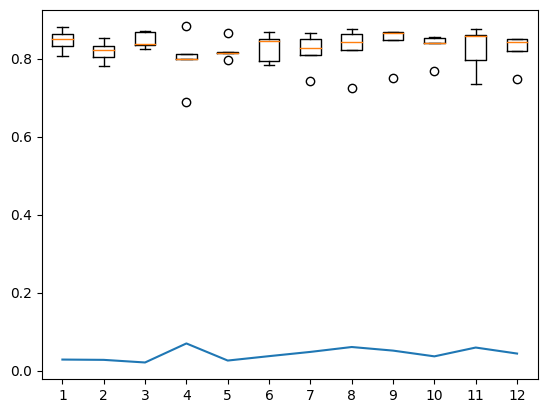

In [ ]:
plt.boxplot(df[df.columns]);
plt.plot([i for i in range(1, len(df.columns) + 1)], df.describe().transpose()["std"]);

We will show its mean and standar deviation too.

In [ ]:
df.describe().transpose()[["mean", "std"]]

,mean,std
11True,0.846133,0.028193
11False,0.818387,0.027419
1-1True,0.847044,0.020713
1-1False,0.795443,0.069519
31True,0.822123,0.025654
31False,0.828182,0.036933
3-1True,0.819460,0.047834
3-1False,0.825306,0.060372
51True,0.840243,0.051144
51False,0.831535,0.036417


We save the results in order to plot them together.

In [ ]:
folds = [["CM" + r[0], *r[1]] for r in results.items()]
df = pd.read_csv("SSA_testing.csv")
_df = pd.DataFrame(folds, columns = df.columns)
df = pd.concat([df, _df])
df.to_csv("SSA_testing.csv", index = False)